In [2]:
import yfinance as yf
import pandas as pd

# Define the stock tickers and time period
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
start_date = '2020-01-01'
end_date = '2023-01-01'

# Download historical data for the tickers
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [4]:
returns = data.pct_change().dropna()

In [5]:
returns

Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2020-01-03 00:00:00+00:00,-0.009722,-0.012139,-0.005231,-0.012452
2020-01-06 00:00:00+00:00,0.007969,0.014886,0.026654,0.002585
2020-01-07 00:00:00+00:00,-0.004703,0.002092,-0.001931,-0.009118
2020-01-08 00:00:00+00:00,0.016086,-0.007809,0.007118,0.015929
2020-01-09 00:00:00+00:00,0.021241,0.004799,0.010498,0.012493
...,...,...,...,...
2022-12-23 00:00:00+00:00,-0.002798,0.017425,0.016750,0.002267
2022-12-27 00:00:00+00:00,-0.013878,-0.025924,-0.020621,-0.007414
2022-12-28 00:00:00+00:00,-0.030685,-0.014692,-0.015677,-0.010255


In [6]:
# Calculate expected returns (mean daily returns)
expected_returns = returns.mean()

# Calculate covariance matrix of returns
cov_matrix = returns.cov()

In [7]:
expected_returns

Ticker
AAPL     0.001024
AMZN     0.000141
GOOGL    0.000573
MSFT     0.000808
dtype: float64

In [8]:
cov_matrix

Ticker,AAPL,AMZN,GOOGL,MSFT
Ticker,,,,
AAPL,0.000541,0.000380,0.000370,0.000413
AMZN,0.000380,0.000606,0.000364,0.000378
GOOGL,0.000370,0.000364,0.000473,0.000395
MSFT,0.000413,0.000378,0.000395,0.000479


In [9]:
import numpy as np

# Risk-free rate assumption
risk_free_rate = 0.05

# Portfolio performance functions
def portfolio_performance(weights, expected_returns, cov_matrix):
    # Portfolio return
    portfolio_return = np.sum(weights * expected_returns) * 252  # Annualized
    # Portfolio volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # Annualized
    return portfolio_return, portfolio_volatility

def sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    p_return, p_volatility = portfolio_performance(weights, expected_returns, cov_matrix)
    return (p_return - risk_free_rate) / p_volatility

In [ ]:
# Maximizing the sharpe ratio using sequential least square quadratic programming
from scipy.optimize import minimize

# Constraint: Sum of weights = 1, equality constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: Weight of each asset is between 0 and 1
bounds = tuple((0, 1) for asset in range(len(tickers)))

# Initial guess (equal weight for each asset that is 0.25
initial_weights = 4 * [1. / 4]

# Optimization to maximize Sharpe ratio
optimized_result = minimize(lambda w: -sharpe_ratio(w, expected_returns, cov_matrix, risk_free_rate),
                            initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)


optimal_weights = optimized_result.x

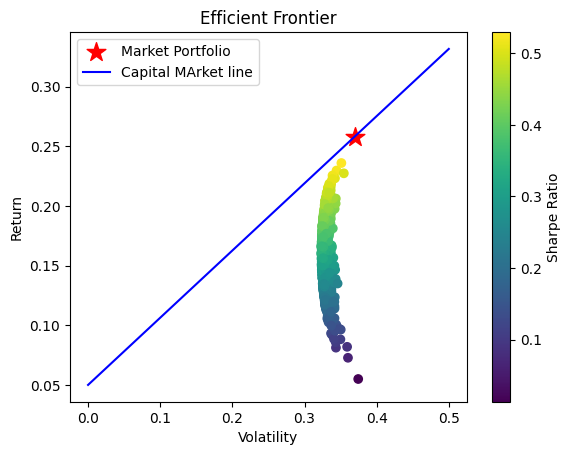

In [17]:
# plotting the market portfolio 
import matplotlib.pyplot as plt

def efficient_frontier(expected_returns, cov_matrix, num_portfolios=1000):
    results = np.zeros((3, num_portfolios))  # To store returns, volatility, Sharpe ratio
    weights_array = []

    for i in range(num_portfolios):
        # Randomly generate portfolio weights
        weights = np.random.random(len(tickers))
        weights = weights/np.sum(weights)
        weights_array.append(weights)

        portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)
        results[0, i] = portfolio_volatility
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_volatility  # Sharpe Ratio

    return results, weights_array



optimal_return, optimal_volatility = portfolio_performance(optimal_weights, expected_returns, cov_matrix)
optimal_sharpe_ratio = (optimal_return - risk_free_rate) / optimal_volatility

    
# Define the Capital Market Line (CML)
def cml(x):
    return risk_free_rate + ((optimal_return - risk_free_rate) / optimal_volatility) * x
    
# Volatility range for plotting
volatilities = np.linspace(0, 0.5, 100)
cml_returns = cml(volatilities)

# Generate portfolios and plot
results, _ = efficient_frontier(expected_returns, cov_matrix)
plt.scatter(optimal_volatility, optimal_return, color='red', marker='*', s=200, label=f'Market Portfolio')

plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.plot(volatilities, cml_returns, color='blue',label='Capital MArket line')
plt.legend()

